In [1]:
from dataclasses import dataclass, field
import copy
from enum import Enum, auto
import random
import pandas as pd
import seaborn as sns


import blackjack as bj
from blackjack import Hand, HandScore, Action, make_hand

In [2]:
h = HandScore(11, True)
h

s11

In [3]:
h.add_card(10)

s21

In [4]:
h.add_card(10).add_card(10)

h21

In [5]:
h

s11

In [6]:
h.add_card(3)

s14

In [7]:
h.add_card(3).add_card(10)

h14

In [8]:
all_scores = [HandScore(i, False) for i in range(0, 23)] + [HandScore(i, True) for i in range(11, 22)]
all_scores

[h00,
 h01,
 h02,
 h03,
 h04,
 h05,
 h06,
 h07,
 h08,
 h09,
 h10,
 h11,
 h12,
 h13,
 h14,
 h15,
 h16,
 h17,
 h18,
 h19,
 h20,
 h21,
 h22,
 s11,
 s12,
 s13,
 s14,
 s15,
 s16,
 s17,
 s18,
 s19,
 s20,
 s21]

In [9]:
h = Hand()
h

Hand(score=h00, cards=[], doubled=False)

In [10]:
h.add_card(6) # start a hand with a 6

Hand(score=h06, cards=[6], doubled=False)

In [11]:
h.add_card(11) # show that J (11) counts as 10 points

Hand(score=h16, cards=[6, 11], doubled=False)

In [12]:
h.add_card(7), bj.is_busted(h) # bust (show that 23 is counted as 22)

(Hand(score=h22, cards=[6, 11, 7], doubled=False), True)

In [13]:
# OK, now let's try another hand with aces
h = Hand()
h.add_card(1) # should be a soft 11

Hand(score=s11, cards=[1], doubled=False)

In [14]:
h.add_card(1) # two aces: should be a soft 12

Hand(score=s12, cards=[1, 1], doubled=False)

In [15]:
h.add_card(11) # two aces and a J: should be a hard 12

Hand(score=h12, cards=[1, 1, 11], doubled=False)

In [16]:
# OK, now let's try another hand with a blackjack
h = Hand()
h.add_card(1) # should be a soft 11
h.add_card(10)
h, bj.is_blackjack(h)

(Hand(score=s21, cards=[1, 10], doubled=False), True)

## Now define gameplay and strategy

In [17]:
[bj.deal_card() for _ in range(10)]

[12, 8, 2, 8, 8, 7, 6, 9, 11, 1]

In [18]:
bj.play_one_round([bj.strat_nobust, bj.strat_nobust])

[('strat_nobust',
  Hand(score=s21, cards=[13, 1], doubled=False),
  Hand(score=h19, cards=[9, 13], doubled=False),
  <HandOutcome.BLACKJACK: 1.5>),
 ('strat_nobust',
  Hand(score=s21, cards=[13, 1], doubled=False),
  Hand(score=h19, cards=[9, 13], doubled=False),
  <HandOutcome.BLACKJACK: 1.5>)]

## Aggregate and summarize the data from the simulations

In [19]:

def generate_row_from_player(player):
    (strat, hand_p, hand_d, outcome) = player
    return {'strategy': strat, 'hand_start': hand_p.cards[:2], 'dealer_card': hand_d.cards[0], 'hand_end': hand_p.cards, 'dealer_hand': hand_d.cards, 'outcome': outcome}

def generate_rows_from_round(r):
    return [generate_row_from_player(player) for player in r]

strat_nobust = bj.strat_nobust
strat_dealer = bj.strat_dealer
generate_rows_from_round(bj.play_one_round([bj.strat_nobust, bj.strat_dealer]))


[{'strategy': 'strat_nobust',
  'hand_start': [13, 11],
  'dealer_card': 7,
  'hand_end': [13, 11],
  'dealer_hand': [7, 6, 2, 12],
  'outcome': <HandOutcome.WIN: 1>},
 {'strategy': 'strat_dealer',
  'hand_start': [13, 11],
  'dealer_card': 7,
  'hand_end': [13, 11],
  'dealer_hand': [7, 6, 2, 12],
  'outcome': <HandOutcome.WIN: 1>}]

In [20]:
def run_n_sim_trials(strats, n):
    sims = [generate_rows_from_round(bj.play_one_round(strats)) for _ in range(n)]
    results = pd.DataFrame([player for round in sims for player in round])
    results['outcome_value'] = results['outcome'].apply(lambda x: x.value)
    results['outcome_name'] = results['outcome'].apply(lambda x: str(x)[12:])
    return results

def summarize_totals(sims):
    def outcome_name(x): return x.head(1) # The function name will be used as the column name
    outcome_counts = sims.groupby(['strategy', 'outcome_value'])['outcome_name'].agg([len, outcome_name])
    outcome_summary = outcome_counts.reset_index().set_index('strategy').drop(['outcome_value'], axis=1).pivot(columns=['outcome_name'])

    # The empty cells are NaNs; fill the NaNs and convert back to int
    for col in outcome_summary.columns:
        outcome_summary[col] = outcome_summary[col].fillna(0).apply(int)
        
    outcome_summary['mean_outcome'] = sims.groupby('strategy')['outcome_value'].mean()
    
    return outcome_summary


sim_results = run_n_sim_trials([strat_nobust, strat_dealer], 1000)
sim_results, summarize_totals(sim_results)

(          strategy hand_start  dealer_card        hand_end     dealer_hand  \
 0     strat_nobust     [2, 4]            2      [2, 4, 11]       [2, 9, 9]   
 1     strat_dealer     [2, 4]            2  [2, 4, 12, 12]       [2, 9, 9]   
 2     strat_nobust     [1, 9]           13          [1, 9]  [13, 2, 2, 13]   
 3     strat_dealer     [1, 9]           13          [1, 9]  [13, 2, 2, 13]   
 4     strat_nobust     [6, 4]           11       [6, 4, 9]         [11, 8]   
 ...            ...        ...          ...             ...             ...   
 1995  strat_dealer    [4, 12]            4      [4, 12, 6]       [4, 6, 7]   
 1996  strat_nobust    [10, 6]            4         [10, 6]       [4, 3, 1]   
 1997  strat_dealer    [10, 6]            4      [10, 6, 3]       [4, 3, 1]   
 1998  strat_nobust     [4, 1]            4          [4, 1]      [4, 8, 11]   
 1999  strat_dealer     [4, 1]            4   [4, 1, 12, 6]      [4, 8, 11]   
 
                outcome  outcome_value outcome_nam

In [21]:
def strat_simple(score_p, score_d):
    if score_p.points == 11:  return Action.DOUBLE
    if score_p.points >= 17:  return Action.STAND
    if score_p.points <= 11:  return Action.HIT
    if score_d.points in (range(3,7)):  return Action.STAND
    else:  return Action.HIT
        
strat_simple.name = 'simple'


sims = run_n_sim_trials([strat_simple], 1000)
sims.head(10), summarize_totals(sims)

(  strategy hand_start  dealer_card       hand_end   dealer_hand  \
 0   simple     [9, 1]            1         [9, 1]       [1, 12]   
 1   simple    [6, 13]            7     [6, 13, 3]       [7, 10]   
 2   simple    [11, 9]            2        [11, 9]     [2, 9, 7]   
 3   simple    [3, 12]           10     [3, 12, 7]    [10, 4, 9]   
 4   simple     [2, 8]            2  [2, 8, 5, 12]    [2, 10, 7]   
 5   simple     [5, 5]            2     [5, 5, 13]   [2, 10, 10]   
 6   simple    [9, 12]           11        [9, 12]       [11, 7]   
 7   simple     [4, 9]            5         [4, 9]  [5, 2, 9, 5]   
 8   simple     [9, 6]            4         [9, 6]    [4, 8, 13]   
 9   simple    [7, 11]           11        [7, 11]   [11, 4, 12]   
 
             outcome  outcome_value outcome_name  
 0  HandOutcome.LOSE           -1.0         LOSE  
 1   HandOutcome.WIN            1.0          WIN  
 2   HandOutcome.WIN            1.0          WIN  
 3   HandOutcome.WIN            1.0          W

In [22]:
summarize_totals(run_n_sim_trials([strat_dealer, strat_nobust, strat_simple], 10000))


len                                         mean_outcome
outcome_name BLACKJACK  LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                                   
simple             464  4574         238  792  3595        337      -0.0085
strat_dealer       464  4972           0  900  3664          0      -0.0612
strat_nobust       464  5128           0  586  3822          0      -0.0610

## Simulate specific situations to determine strategy

In [23]:
# 12 vs deuce

hand_p = make_hand([5, 7])
hand_d = make_hand([2])

hand_p, hand_d

(Hand(score=h12, cards=[5, 7], doubled=False),
 Hand(score=h02, cards=[2], doubled=False))

In [24]:
# Implement a strategy that composes conditions and actions

def cond_12_2(score_p, score_d):
    return score_p.points == 12 and score_d.points == 2 and not score_p.soft
conditions = [(cond_12_2, Action.STAND)]

def generate_strat_conditional(strat_base, conditions):
    def strat_cond(score_p, score_d):
        for (condition, action) in conditions:
            if condition(score_p, score_d): return action
        return strat_base(score_p, score_d)
    strat_cond.name = 'strat_cond'
    return strat_cond
    
strat_cond = generate_strat_conditional(strat_simple, conditions)

In [25]:
def gen_cond_strategies(strat_base, condition, actions):
    def gen_strat_action(strat_base, condition, action):
        strat = generate_strat_conditional(strat_base, [(condition, action)])
        strat.name = repr(action)
        return strat
    
    strats = [gen_strat_action(strat_base, condition, a) for a in actions]
    return strats
    



strats = gen_cond_strategies(strat_simple, cond_12_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>]

In [26]:
bj.complete_one_round(strats, hand_p, hand_d, bj.deal_card())

[('<Action.HIT: 2>',
  Hand(score=h18, cards=[5, 7, 6], doubled=False),
  Hand(score=h22, cards=[2, 3, 13, 13], doubled=False),
  <HandOutcome.WIN: 1>),
 ('<Action.STAND: 1>',
  Hand(score=h12, cards=[5, 7], doubled=False),
  Hand(score=h22, cards=[2, 3, 13, 13], doubled=False),
  <HandOutcome.WIN: 1>),
 ('<Action.DOUBLE: 3>',
  Hand(score=h21, cards=[5, 7, 9], doubled=True),
  Hand(score=h22, cards=[2, 3, 13, 13], doubled=False),
  <HandOutcome.WIN_DOUBLE: 2>)]

In [27]:
# TODO reduce duplication with run_n_sim_trials
def run_n_sim_trials_from_state(strats, hand_p, hand_d, n):
    sims = [generate_rows_from_round(bj.complete_one_round(strats, hand_p, hand_d, bj.deal_card())) for _ in range(n)]
    results = pd.DataFrame([player for round in sims for player in round])
    results['outcome_value'] = results['outcome'].apply(lambda x: x.value)
    results['outcome_name'] = results['outcome'].apply(lambda x: str(x)[12:])
    return results

sims = run_n_sim_trials_from_state(strats, hand_p, hand_d, 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        5902  504     0       3594      -0.4616
<Action.HIT: 2>     6044           0  667  3289          0      -0.2755
<Action.STAND: 1>   6269           0    0  3731          0      -0.2538

In [28]:
# Soft 12 vs 2
hand_12s = make_hand([1, 1])

hand_12s, hand_d

(Hand(score=s12, cards=[1, 1], doubled=False),
 Hand(score=h02, cards=[2], doubled=False))

In [29]:
def cond_12s_2(score_p, score_d):
    return score_p == HandScore(12, True) and score_d.points == 2

strats = gen_cond_strategies(strat_simple, cond_12s_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>]

In [30]:
sims = run_n_sim_trials_from_state(strats+[strat_simple], hand_12s, hand_d, 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        6382    0     0       3618      -0.5528
<Action.HIT: 2>     4875         417  783  3205        720      -0.1064
<Action.STAND: 1>   6382           0    0  3618          0      -0.2764
simple              4826         427  814  3182        751      -0.0996

In [31]:
summarize_totals(run_n_sim_trials_from_state([strat_simple, strat_cond], hand_p, hand_d, 10*1000))

len            mean_outcome
outcome_name  LOSE PUSH   WIN             
strategy                                  
simple        6066  637  3297      -0.2769
strat_cond    6416    0  3584      -0.2832

In [32]:
# soft 13 vs 6
def cond_13s_6(score_p, score_d):
    return score_p == HandScore(13, True) and score_d.points == 6



strats = gen_cond_strategies(strat_simple, cond_13s_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = run_n_sim_trials_from_state(strats+[strat_simple], bj.make_hand([1, 2]), bj.make_hand([6]), 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        5781    0     0       4219      -0.3124
<Action.HIT: 2>     4552         323  295  4105        725       0.0357
<Action.STAND: 1>   5781           0    0  4219          0      -0.1562
simple              5781           0    0  4219          0      -0.1562

In [33]:
# 10 v 6
def cond_10_6(score_p, score_d):
    return score_p.points == 10 and score_d.points == 6

strats = gen_cond_strategies(strat_simple, cond_10_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = run_n_sim_trials_from_state(strats+[strat_simple], make_hand([5, 5]), make_hand([6]), 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        3237  682     0       6081       0.5688
<Action.HIT: 2>     3282           0  675  6043          0       0.2761
<Action.STAND: 1>   5802           0    0  4198          0      -0.1604
simple              3250           0  649  6101          0       0.2851

In [34]:
ACTIONS = [Action.HIT, Action.STAND, Action.DOUBLE]

def test_cond(score_p, score_d, n):
    def cond(p, d):
        return p == score_p and d == score_d
    strats = gen_cond_strategies(strat_simple, cond, ACTIONS)
    hand_p = Hand(score_p) 
    hand_d = make_hand([score_d.points if score_d.points< 11 else 1])
    sims = run_n_sim_trials_from_state(strats, hand_p, hand_d, n)
    return cond, summarize_totals(sims)

test_cond(HandScore(10), HandScore(6), 10000)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                      len                                   mean_outcome
 outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
 strategy                                                               
 <Action.DOUBLE: 3>     0        3245  660     0       6095       0.5700
 <Action.HIT: 2>     3229           0  696  6075          0       0.2846
 <Action.STAND: 1>   5809           0    0  4191          0      -0.1618)

In [35]:
test_cond(HandScore(18), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         157    3    0         40       -1.170
 <Action.HIT: 2>     159           0    1   40          0       -0.595
 <Action.STAND: 1>    50           0   18  132          0        0.410)

In [36]:
test_cond(HandScore(21, True), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0          69   11    0        120        0.510
 <Action.HIT: 2>      69           0   10  121          0        0.260
 <Action.STAND: 1>     0           0   19  181          0        0.905)

In [37]:
def find_winning_action(score_p, score_d, n):
    cond, summary = test_cond(score_p, score_d, n)
    outcomes = summary['mean_outcome']
    # Find the winning strategy
    winner = outcomes[outcomes==outcomes.max()].index[0]
    winning_act = [a for a in ACTIONS if repr(a)==winner][0]

    # Convert results to a dict
    run = outcomes.to_dict()
    run['score_p'] = repr(score_p)
    run['score_d'] = repr(score_d)
    run['winning_act'] = winning_act
    run['winning_act_outcome'] = outcomes.max()

    return (cond, run)

find_winning_action(HandScore(10), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
 {'<Action.DOUBLE: 3>': 0.61,
  '<Action.HIT: 2>': 0.405,
  '<Action.STAND: 1>': -0.12,
  'score_p': 'h10',
  'score_d': 'h06',
  'winning_act': <Action.DOUBLE: 3>,
  'winning_act_outcome': 0.61})

In [38]:
conds = [find_winning_action(p, make_hand([d]).score, 10) for p in all_scores for d in range(1, 3)]
pd.DataFrame([data for _, data in conds]).set_index(['score_p', 'score_d'])

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
h00     s11                    -1.2            -0.40               -0.6   
        h02                     0.4             0.25                0.2   
h01     s11                    -2.0            -0.90               -1.0   
        h02                    -0.8            -0.60               -0.4   
h02     s11                    -2.0            -0.20               -1.0   
...                             ...              ...                ...   
s19     h02                     0.2             0.00                0.4   
s20     s11                     0.4             0.30                0.6   
        h02                     0.4            -0.10                0.8   
s21     s11                    -2.0            -0.40                0.2   
        h02                    -0.4             0.20                0.7   

                   winning_act  winning_act_outcome  
score_p score_d                                      
h00     s11         Action.HIT                 -0.4  
        h02      Action.DOUBLE                  0.4  
h01     s11         Action.HIT                 -0.9  
        h02       Action.STAND                 -0.4  
h02     s11         Action.HIT                 -0.2  
...                        ...                  ...  
s19     h02       Action.STAND                  0.4  
s20     s11       Action.STAND                  0.6  
        h02       Action.STAND                  0.8  
s21     s11       Action.STAND                  0.2  
        h02       Action.STAND                  0.7  

[68 rows x 5 columns]

In [39]:
conds = [find_winning_action(HandScore(p), make_hand([d]).score, 1*1000) for p in range(10, 19) for d in range(1, 11)]
conds

[(<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': -0.516,
   '<Action.HIT: 2>': -0.1865,
   '<Action.STAND: 1>': -0.716,
   'score_p': 'h10',
   'score_d': 's11',
   'winning_act': <Action.HIT: 2>,
   'winning_act_outcome': -0.1865}),
 (<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': 0.422,
   '<Action.HIT: 2>': 0.1915,
   '<Action.STAND: 1>': -0.24,
   'score_p': 'h10',
   'score_d': 'h02',
   'winning_act': <Action.DOUBLE: 3>,
   'winning_act_outcome': 0.422}),
 (<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': 0.398,
   '<Action.HIT: 2>': 0.246,
   '<Action.STAND: 1>': -0.21,
   'score_p': 'h10',
   'score_d': 'h03',
   'winning_act': <Action.DOUBLE: 3>,
   'winning_act_outcome': 0.398}),
 (<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': 0.38,
   '<Action.HIT: 2>': 0.232,
   '<Action.STAND: 1>': -0.248,
   'score_p': 'h10',
   'score_d': 'h04',
   'winning_act': <Action.DOU

In [40]:
outputs = pd.DataFrame([data for _, data in conds]).set_index(['score_p', 'score_d'])
outputs

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
h10     s11                  -0.516          -0.1865             -0.716   
        h02                   0.422           0.1915             -0.240   
        h03                   0.398           0.2460             -0.210   
        h04                   0.380           0.2320             -0.248   
        h05                   0.542           0.2260             -0.174   
...                             ...              ...                ...   
h18     h06                  -1.138          -0.6370              0.285   
        h07                  -1.152          -0.5820              0.394   
        h08                  -1.268          -0.5750              0.061   
        h09                  -1.228          -0.6460             -0.193   
        h10                  -1.446          -0.6880             -0.225   

                   winning_act  winning_act_outcome  
score_p score_d                                      
h10     s11         Action.HIT              -0.1865  
        h02      Action.DOUBLE               0.4220  
        h03      Action.DOUBLE               0.3980  
        h04      Action.DOUBLE               0.3800  
        h05      Action.DOUBLE               0.5420  
...                        ...                  ...  
h18     h06       Action.STAND               0.2850  
        h07       Action.STAND               0.3940  
        h08       Action.STAND               0.0610  
        h09       Action.STAND              -0.1930  
        h10       Action.STAND              -0.2250  

[90 rows x 5 columns]

In [41]:
test_cond(HandScore(18), HandScore(11, True), 1000)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         856   22    0        122       -1.468
 <Action.HIT: 2>     871           0   23  106          0       -0.765
 <Action.STAND: 1>   600           0  108  292          0       -0.308)

<AxesSubplot:xlabel='score_d', ylabel='score_p'>

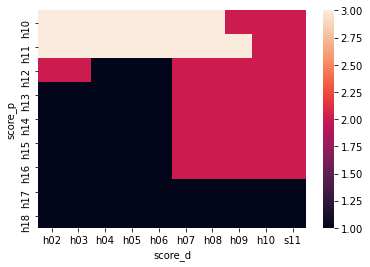

In [42]:
# Visualize the winning action by starting condition
sns.heatmap(outputs['winning_act'].apply(lambda x: x.value).unstack())


<AxesSubplot:xlabel='score_d', ylabel='score_p'>

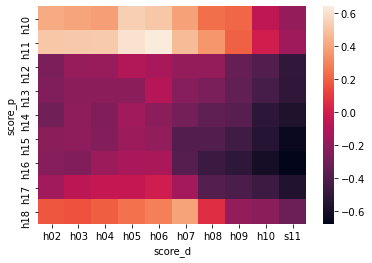

In [43]:
# Visualize the average outcome by starting condition
sns.heatmap(outputs['winning_act_outcome'].unstack())

In [44]:
[(cond, output['winning_act']) for cond, output in conds]

[(<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)

In [45]:
strat_derived = generate_strat_conditional(strat_simple, [(cond, output['winning_act']) for cond, output in conds])
strat_derived.name = 'strat_derived'

In [46]:
sims = run_n_sim_trials([strat_simple, strat_derived], 100)
sims.head(10), summarize_totals(sims)

(        strategy hand_start  dealer_card          hand_end     dealer_hand  \
 0         simple    [13, 1]           10           [13, 1]         [10, 9]   
 1  strat_derived    [13, 1]           10           [13, 1]         [10, 9]   
 2         simple     [2, 7]            8        [2, 7, 10]   [8, 2, 4, 10]   
 3  strat_derived     [2, 7]            8      [2, 7, 6, 3]   [8, 2, 4, 10]   
 4         simple     [4, 5]           10      [4, 5, 5, 3]         [10, 9]   
 5  strat_derived     [4, 5]           10      [4, 5, 2, 7]         [10, 9]   
 6         simple     [9, 7]            1        [9, 7, 13]  [1, 1, 12, 13]   
 7  strat_derived     [9, 7]            1        [9, 7, 10]  [1, 1, 12, 13]   
 8         simple     [6, 3]           11  [6, 3, 4, 3, 13]         [11, 8]   
 9  strat_derived     [6, 3]           11        [6, 3, 13]         [11, 8]   
 
                  outcome  outcome_value outcome_name  
 0  HandOutcome.BLACKJACK            1.5    BLACKJACK  
 1  HandOutcome.B

In [47]:
sims = run_n_sim_trials([strat_simple, strat_derived], 100*1000)
sims.head(10), summarize_totals(sims)

(        strategy hand_start  dealer_card    hand_end    dealer_hand  \
 0         simple     [6, 2]            5   [6, 2, 8]      [5, 9, 7]   
 1  strat_derived     [6, 2]            5   [6, 2, 4]      [5, 9, 7]   
 2         simple     [2, 9]            8   [2, 9, 3]     [8, 5, 10]   
 3  strat_derived     [2, 9]            8  [2, 9, 11]     [8, 5, 10]   
 4         simple     [1, 3]            4      [1, 3]   [4, 7, 1, 8]   
 5  strat_derived     [1, 3]            4      [1, 3]   [4, 7, 1, 8]   
 6         simple     [8, 2]           13  [8, 2, 10]        [13, 1]   
 7  strat_derived     [8, 2]           13  [8, 2, 13]        [13, 1]   
 8         simple    [12, 7]            2     [12, 7]  [2, 2, 12, 9]   
 9  strat_derived    [12, 7]            2     [12, 7]  [2, 2, 12, 9]   
 
                   outcome  outcome_value outcome_name  
 0        HandOutcome.LOSE           -1.0         LOSE  
 1        HandOutcome.LOSE           -1.0         LOSE  
 2  HandOutcome.WIN_DOUBLE         

In [48]:
sims

,strategy,hand_start,dealer_card,hand_end,dealer_hand,outcome,outcome_value,outcome_name
0,simple,"[6, 2]",5,"[6, 2, 8]","[5, 9, 7]",HandOutcome.LOSE,-1.0,LOSE
1,strat_derived,"[6, 2]",5,"[6, 2, 4]","[5, 9, 7]",HandOutcome.LOSE,-1.0,LOSE
2,simple,"[2, 9]",8,"[2, 9, 3]","[8, 5, 10]",HandOutcome.WIN_DOUBLE,2.0,WIN_DOUBLE
3,strat_derived,"[2, 9]",8,"[2, 9, 11]","[8, 5, 10]",HandOutcome.WIN_DOUBLE,2.0,WIN_DOUBLE
4,simple,"[1, 3]",4,"[1, 3]","[4, 7, 1, 8]",HandOutcome.LOSE,-1.0,LOSE
...,...,...,...,...,...,...,...,...
199995,strat_derived,"[1, 12]",10,"[1, 12]","[10, 3, 7]",HandOutcome.BLACKJACK,1.5,BLACKJACK
199996,simple,"[8, 2]",4,"[8, 2, 10]","[4, 4, 3, 3, 10]",HandOutcome.WIN,1.0,WIN
199997,strat_derived,"[8, 2]",4,"[8, 2, 13]","[4, 4, 3, 3, 10]",HandOutcome.WIN_DOUBLE,2.0,WIN_DOUBLE
199998,simple,"[6, 5]",8,"[6, 5, 2]","[8, 6, 7]",HandOutcome.LOSE_DOUBLE,-2.0,LOSE_DOUBLE
